In this tutorial, we will use the HST data of M13 for our tutorial. The data can be found [here](http://hla.stsci.edu/hlaview.html#Inventory|filterText%3D%7C12%3Ahlsp_appp_hst_wfpc2_sfd-pu6finn01_f606w_v2_sci%09%7C%24filterTypes%3Dchar|query_string=M%2013&posfilename=&poslocalname=&posfilecount=&listdelimiter=whitespace&listformat=degrees&RA=250.423460&Dec=36.461310&Radius=0.200000&inst-control=all&inst=ACS&inst=ACSGrism&inst=WFC3&inst=WFPC2&inst=NICMOS&inst=NICGRISM&inst=COS&inst=WFPC2-PC&inst=STIS&inst=FOS&inst=GHRS&imagetype=best&prop_id=&spectral_elt=&proprietary=both&preview=1&output_size=256&cutout_size=12.8|ra=&dec=&sr=&level=&image=&inst=ACS%2CACSGrism%2CWFC3%2CWFPC2%2CNICMOS%2CNICGRISM%2CCOS%2CWFPC2-PC%2CSTIS%2CFOS%2CGHRS&ds=).

For your information, I plotted the image, grid, and the region I cropped for future use:


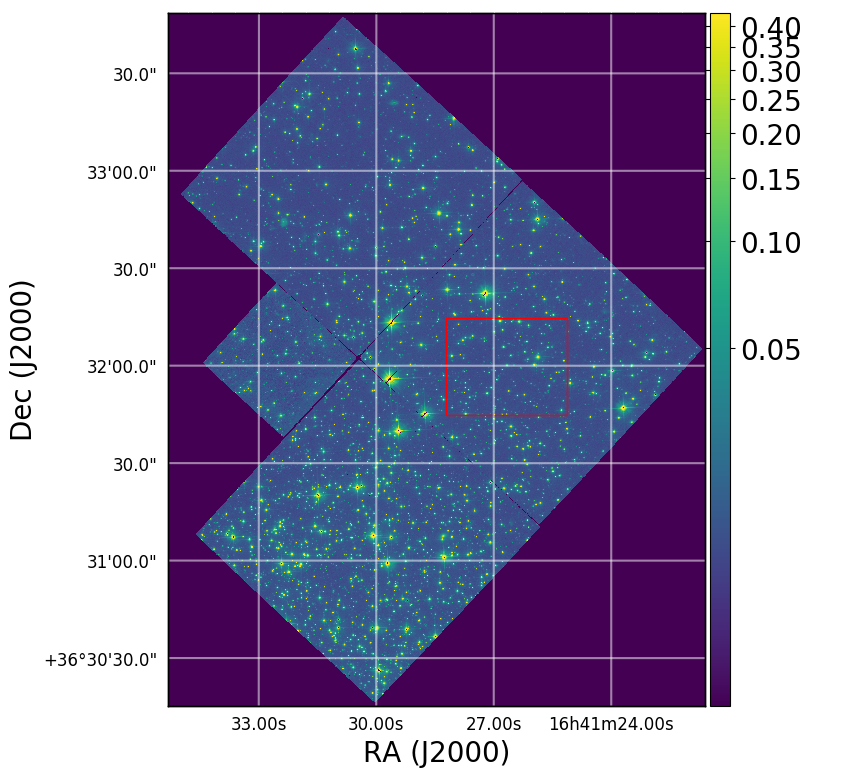

In [4]:
from IPython.display import Image
Image('HST_Tutorial/m13.png', width=500)

The code to generate the image was made by using [APLpy](http://aplpy.readthedocs.io/en/stable/), which can be installed by `conda install -c astropy aplpy`:

```python
import aplpy

m13 = aplpy.FITSFigure('M13.fits')
m13.show_colorscale(cmap='viridis', stretch='log', vmin=0.005)
m13.add_grid()
m13.tick_labels.set_font(size=12)
m13.set_theme(theme='ds9')
x0, y0   = m13.pixel2world( 900, 900)
x1, y1   = m13.pixel2world(1200, 1200)
width    = x1-x0
height   = y1-y0
x_c, y_c = x0 + width/2, y0+height/2
m13.show_rectangles(x_c, y_c, width=width, height=height, color='red')
m13.add_colorbar()
m13.colorbar.show()
m13.save('m13.png')
```

After cropping, the image looks like:

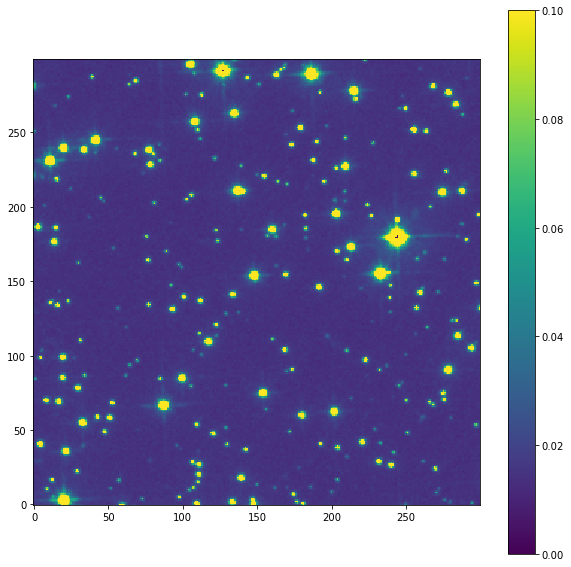

In [15]:
import matplotlib.pyplot as plt
from astropy.io import fits

hdu = fits.open('HST_Tutorial/M13.fits')
img = hdu[0].data[900:1200, 900:1200]

plt.figure(figsize=(10,10))
plt.imshow(img, vmax=0.10, origin='lower')
plt.colorbar()
plt.show()

From ginga, I obtained the FWHM is about 2.5 pixels. Let me define the detection threshold by using the [MAD method](http://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html):

In [29]:
from astropy.stats import mad_std

FWHM   = 2.5
sky_th = 5    # sky_th * sky_sigma will be used for detection lower limit
sky_s  = mad_std(img)
thresh = sky_th*sky_s
print(' sky_s x sky_th = threshold')
print('{0:6.4f} x {1:4d}   =   {2:6.4f}\n'.format(sky_s, sky_th, thresh))

 sky_s x sky_th = threshold
0.0015 x    5   =   0.0073



I will do the starfinding to this image. The documentation for `DAOStarFinder` is too well summarized in [photutils documentation](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder), so I refrain from making further comments than the demonstration. For the actual definitions of the sharpness and roundness parameters, see the [source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/detection/findstars.html). Find `g_roundness` or `roundness1` for the `GROUND` parameter of `DAOFIND`, and `roundness1` for `SROUND` of `DAOFIND`.


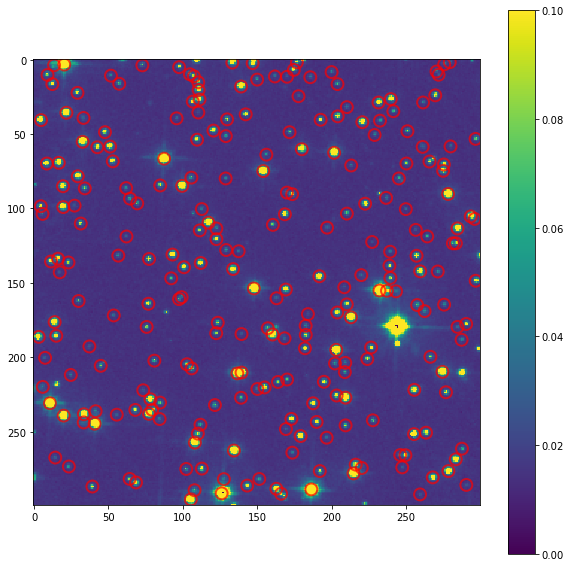

In [37]:
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from photutils import CircularAperture as CircAp

find   = DAOStarFinder(fwhm=FWHM, threshold=thresh,
                      sharplo=0.2, sharphi=1.0,  # default values 
                      roundlo=-1.0, roundhi=1.0, # default values
                      sigma_radius=1.5,          # default values
                      ratio=1.0,                 # 1.0: circular gaussian
                      exclude_border=True)       # To exclude sources near edges

# The DAOStarFinder object ("find") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = find(img)

# Use the object "found" for aperture photometry:
# save XY coordinates:
coord = (found['xcentroid'], found['ycentroid']) 

# Save apertures as circular, 4 pixel radius, at each (X, Y)
apert = CircAp(coord, r=4.)  

# Draw image and overplot apertures:
plt.figure(figsize=(10,10))
plt.imshow(img, vmax=0.10)
apert.plot(color='red', lw=2., alpha=0.7)
plt.colorbar()
plt.show()

We now have the X, Y coordinates of the detected stars. If you are unfamiliat with the astropy table object, you can save the coordinates in numpy format by `imgXY = np.array(coord)`, so that `imgXY[0]` and `[1]` contains all X and Y coordinates, respectively. You may want to do `X, Y = np.array(coord)` to make two d